BioPandas

Author: Sebastian Raschka <mail@sebastianraschka.com>  
License: BSD 3 clause  
Project Website: http://rasbt.github.io/biopandas/  
Code Repository: https://github.com/rasbt/biopandas  

In [1]:
%load_ext watermark
%watermark -d -u -p pandas,biopandas

last updated: 2020-10-22 

pandas 1.1.3
biopandas 0.2.7


In [2]:
from biopandas.pdb import PandasPdb
import pandas as pd
pd.set_option('display.width', 600)
pd.set_option('display.max_columns', 8)

# Working with PDB Structures in DataFrames

## Loading PDB Files

There are 2 1/2 ways to load a PDB structure into a `PandasPdb` object.


#### 1
PDB files can be directly fetched from The Protein Data Bank at [http://www.rcsb.org](http://www.rcsb.org) via its unique 4-letter after initializing a new [`PandasPdb`](../api/biopandas.pdb#pandaspdb) object and calling the [`fetch_pdb`](../api/biopandas.pdb#pandaspdbfetch_pdb) method:

In [3]:
import pandas as pd
import numpy as np
import sys
import gzip
from warnings import warn
try:
    from urllib.request import urlopen
    from urllib.error import HTTPError, URLError
except ImportError:
    from urllib2 import urlopen, HTTPError, URLError  # Python 2.7 compatible
from biopandas.pdb.engines import pdb_records
from biopandas.pdb.engines import pdb_df_columns
from biopandas.pdb.engines import amino3to1dict
import warnings
from distutils.version import LooseVersion

    
    
class PandasPdb(object):
    """
    Object for working with Protein Databank structure files.

    Attributes
    ----------
    df : dict
        Dictionary storing pandas DataFrames for PDB record sections.
        The dictionary keys are {'ATOM', 'HETATM', 'ANISOU', 'OTHERS'}
        where 'OTHERS' contains all entries that are not parsed as
        'ATOM', 'HETATM', or 'ANISOU'.

    pdb_text : str
        PDB file contents in raw text format.

    pdb_path : str
        Location of the PDB file that was read in via `read_pdb`
        or URL of the page where the PDB content was fetched from
        if `fetch_pdb` was called.

    header : str
        PDB file description.

    code : str
        PDB code

    """
    def __init__(self):
        self._df = {}
        self.pdb_text = ''
        self.header = ''
        self.code = ''
        self._get_dict = {}
        self.pdb_path = ''

    @property
    def df(self):
        """Acccess dictionary of pandas DataFrames for PDB record sections."""
        return self._df

    @df.setter
    def df(self, value):
        """Assign a new value to the pandas DataFrame"""
        raise AttributeError('Please use `PandasPdb._df = ... ` instead\n'
                             'of `PandasPdb.df = ... ` if you are sure that\n'
                             'you want to overwrite the `df` attribute.')
        # self._df = value

    def read_pdb(self, path):
        """Read PDB files (unzipped or gzipped) from local drive

        Attributes
        ----------
        path : str
            Path to the PDB file in .pdb format or gzipped format (.pdb.gz).

        Returns
        ---------
        self

        """
        self.pdb_path, self.pdb_text = self._read_pdb(path=path)
        self._df = self._construct_df(pdb_lines=self.pdb_text.splitlines(True))
        self.header, self.code = self._parse_header_code()
        return self

    def fetch_pdb(self, pdb_code):
        """Fetches PDB file contents from the Protein Databank at rcsb.org.

        Parameters
        ----------
        pdb_code : str
            A 4-letter PDB code, e.g., "3eiy".

        Returns
        ---------
        self

        """
        self.pdb_path, self.pdb_text = self._fetch_pdb(pdb_code)
        self._df = self._construct_df(pdb_lines=self.pdb_text.splitlines(True))
        return self

    def get(self, s, df=None, invert=False, records=('ATOM', 'HETATM')):
        """Filter PDB DataFrames by properties

        Parameters
        ----------
        s : str  in {'main chain', 'hydrogen', 'c-alpha', 'heavy'}
            String to specify which entries to return.

        df : pandas.DataFrame, default: None
            Optional DataFrame to perform the filter operation on.
            If df=None, filters on self.df['ATOM'].

        invert : bool, default: True
            Inverts the search query. For example if s='hydrogen' and
            invert=True, all but hydrogen entries are returned.

        records : iterable, default: ('ATOM', 'HETATM')
            Specify which record sections to consider. For example, to consider
            both protein and ligand atoms, set `records=('ATOM', 'HETATM')`.
            This setting is ignored if `df` is not set to None.
            For downward compatibility, a string argument is still supported
            but deprecated and will be removed in future versions.

        Returns
        --------
        df : pandas.DataFrame
            Returns a DataFrame view on the filtered entries.

        """
        if isinstance(records, str):
            warnings.warn('Using a string as `records` argument is '
                          'deprecated and will not be supported in future'
                          ' versions. Please use a tuple or'
                          ' other iterable instead', DeprecationWarning)
            records = (records,)

        if not self._get_dict:
            self._get_dict = self._init_get_dict()
        if s not in self._get_dict.keys():
            raise AttributeError('s must be in %s' % self._get_dict.keys())
        if not df:
            df = pd.concat(objs=[self.df[i] for i in records])
        return self._get_dict[s](df, invert=invert)

    def impute_element(self, records=('ATOM', 'HETATM'), inplace=False):
        """Impute element_symbol from atom_name section.

        Parameters
        ----------
        records : iterable, default: ('ATOM', 'HETATM')
            Coordinate sections for which the element symbols should be
            imputed.

        inplace : bool, (default: False
            Performs the operation in-place if True and returns a copy of the
            PDB DataFrame otherwise.

        Returns
        ---------
        DataFrame

        """
        if inplace:
            t = self.df
        else:
            t = self.df.copy()
            for d in self.df:
                t[d] = self.df[d].copy()

        for sec in records:
            t[sec]['element_symbol'] = \
                t[sec][['atom_name', 'element_symbol']].\
                apply(lambda x: x[0][1]
                      if len(x[1]) == 3
                      else x[0][0], axis=1)
        return t

    @staticmethod
    def rmsd(df1, df2, s=None, invert=False):
        """Compute the Root Mean Square Deviation between molecules.

        Parameters
        ----------
        df1 : pandas.DataFrame
            DataFrame with HETATM, ATOM, and/or ANISOU entries.

        df2 : pandas.DataFrame
            Second DataFrame for RMSD computation against df1. Must have the
            same number of entries as df1.

        s : {'main chain', 'hydrogen', 'c-alpha', 'heavy', 'carbon'} or None,
            default: None
            String to specify which entries to consider. If None, considers
            all atoms for comparison.

        invert : bool, default: False
            Inverts the string query if true. For example, the setting
            `s='hydrogen', invert=True` computes the RMSD based on all
            but hydrogen atoms.

        Returns
        ---------
        rmsd : float
            Root Mean Square Deviation between df1 and df2

        """
        if df1.shape[0] != df2.shape[0]:
            raise AttributeError('DataFrames have unequal lengths')
        get_dict = PandasPdb._init_get_dict()
        if s:
            if s not in get_dict.keys():
                raise AttributeError('s must be in '
                                     '%s or None' % get_dict.keys())
            df1 = get_dict[s](df1, invert=invert)
            df2 = get_dict[s](df2, invert=invert)

        total = ((df1['x_coord'].values - df2['x_coord'].values)**2 +
                 (df1['y_coord'].values - df2['y_coord'].values)**2 +
                 (df1['z_coord'].values - df2['z_coord'].values)**2)
        rmsd = round((total.sum() / df1.shape[0])**0.5, 4)
        return rmsd

    @staticmethod
    def _init_get_dict():
        """Initialize dictionary for filter operations."""
        get_dict = {'main chain': PandasPdb._get_mainchain,
                    'hydrogen': PandasPdb._get_hydrogen,
                    'c-alpha': PandasPdb._get_calpha,
                    'carbon': PandasPdb._get_carbon,
                    'heavy': PandasPdb._get_heavy}
        return get_dict

    @staticmethod
    def _read_pdb(path):
        """Read PDB file from local drive."""
        r_mode = 'r'
        openf = open
        if path.endswith('.gz'):
            r_mode = 'rb'
            openf = gzip.open
        with openf(path, r_mode) as f:
            txt = f.read()
        if path.endswith('.gz'):
            if sys.version_info[0] >= 3:
                txt = txt.decode('utf-8')
            else:
                txt = txt.encode('ascii')
        return path, txt

    @staticmethod
    def _fetch_pdb(pdb_code):
        """Load PDB file from rcsb.org."""
        txt = None
        url = 'https://files.rcsb.org/download/%s.pdb' % pdb_code.lower()
        try:
            response = urlopen(url)
            txt = response.read()
            if sys.version_info[0] >= 3:
                txt = txt.decode('utf-8')
            else:
                txt = txt.encode('ascii')
        except HTTPError as e:
            print('HTTP Error %s' % e.code)
        except URLError as e:
            print('URL Error %s' % e.args)
        return url, txt

    def _parse_header_code(self):
        """Extract header information and PDB code."""
        code, header = '', ''
        if 'OTHERS' in self.df:

            header = (self.df['OTHERS'][self.df['OTHERS']['record_name'] ==
                      'HEADER'])
            if not header.empty:
                header = header['entry'].values[0]
                s = header.split()
                if s:
                    code = s[-1].lower()
        return header, code

    @staticmethod
    def _get_mainchain(df, invert):
        """Return only main chain atom entries from a DataFrame"""
        if invert:
            mc = df[(df['atom_name'] != 'C') &
                    (df['atom_name'] != 'O') &
                    (df['atom_name'] != 'N') &
                    (df['atom_name'] != 'CA')]
        else:
            mc = df[(df['atom_name'] == 'C') |
                    (df['atom_name'] == 'O') |
                    (df['atom_name'] == 'N') |
                    (df['atom_name'] == 'CA')]
        return mc

    @staticmethod
    def _get_hydrogen(df, invert):
        """Return only hydrogen atom entries from a DataFrame"""
        if invert:
            return df[(df['element_symbol'] != 'H')]
        else:
            return df[(df['element_symbol'] == 'H')]

    @staticmethod
    def _get_heavy(df, invert):
        """Return only heavy atom entries from a DataFrame"""
        if invert:
            return df[df['element_symbol'] == 'H']
        else:
            return df[df['element_symbol'] != 'H']

    @staticmethod
    def _get_calpha(df, invert):
        """Return c-alpha atom entries from a DataFrame"""
        if invert:
            return df[df['atom_name'] != 'CA']
        else:
            return df[df['atom_name'] == 'CA']

    @staticmethod
    def _get_carbon(df, invert):
        """Return c-alpha atom entries from a DataFrame"""
        if invert:
            return df[df['element_symbol'] == 'C']
        else:
            return df[df['element_symbol'] != 'C']

    @staticmethod
    def _construct_df(pdb_lines):
        """Construct DataFrames from list of PDB lines."""
        valids = tuple(pdb_records.keys())
        line_lists = {r: [] for r in valids}
        line_lists['OTHERS'] = []
        for line_num, line in enumerate(pdb_lines):
            if line.strip():
                if line.startswith(valids):
                    record = line[:6].rstrip()
                    line_ele = ['' for _ in range(len(
                        pdb_records[record]) + 1)]
                    for idx, ele in enumerate(pdb_records[record]):
                        line_ele[idx] = (line[ele['line'][0]:ele['line'][1]]
                                         .strip())
                    line_ele[-1] = line_num
                    line_lists[record].append(line_ele)
                else:
                    line_lists['OTHERS'].append([line[:6].rstrip(),
                                                line[6:-1].rstrip(), line_num])

        dfs = {}
        for r in line_lists.items():
            df = pd.DataFrame(r[1], columns=[c['id'] for c in
                                             pdb_records[r[0]]] + ['line_idx'])
            for c in pdb_records[r[0]]:
                try:
                    df[c['id']] = df[c['id']].astype(c['type'])
                except ValueError:
                    # expect ValueError if float/int columns are empty strings
                    df[c['id']] = pd.Series(np.nan, index=df.index)

            dfs[r[0]] = df
        return dfs

    def amino3to1(self, record='ATOM',
                  residue_col='residue_name', fillna='?'):
        """Creates 1-letter amino acid codes from DataFrame

        Non-canonical amino-acids are converted as follows:
        ASH (protonated ASP) => D
        CYX (disulfide-bonded CYS) => C
        GLH (protonated GLU) => E
        HID/HIE/HIP (different protonation states of HIS) = H
        HYP (hydroxyproline) => P
        MSE (selenomethionine) => M

        Parameters
        ----------
        record : str, default: 'ATOM'
            Specfies the record DataFrame.
        residue_col : str,  default: 'residue_name'
            Column in `record` DataFrame to look for 3-letter amino acid
            codes for the conversion.
        fillna : str, default: '?'
            Placeholder string to use for unknown amino acids.

        Returns
        ---------
        pandas.DataFrame : Pandas DataFrame object consisting of two columns,
            `'chain_id'` and `'residue_name'`, where the former contains
            the chain ID of the amino acid and the latter
            contains the 1-letter amino acid code, respectively.

        """
        tmp = self.df[record]
        cmp = 'placeholder'
        indices = []

        residue_number_insertion = (tmp['residue_number'].astype(str)
                                    + tmp['insertion'])

        for num, ind in zip(residue_number_insertion, np.arange(tmp.shape[0])):
            if num != cmp:
                indices.append(ind)
            cmp = num

        transl = tmp.iloc[indices][residue_col].map(
            amino3to1dict).fillna(fillna)

        return pd.concat((tmp.iloc[indices]['chain_id'], transl), axis=1)

    def distance(self, xyz=(0.00, 0.00, 0.00), records=('ATOM', 'HETATM')):
        """Computes Euclidean distance between atoms and a 3D point.

        Parameters
        ----------
        xyz : tuple, default: (0.00, 0.00, 0.00)
            X, Y, and Z coordinate of the reference center for the distance
            computation.
        records : iterable, default: ('ATOM', 'HETATM')
            Specify which record sections to consider. For example, to consider
            both protein and ligand atoms, set `records=('ATOM', 'HETATM')`.
            This setting is ignored if `df` is not set to None.
            For downward compatibility, a string argument is still supported
            but deprecated and will be removed in future versions.

        Returns
        ---------
        pandas.Series : Pandas Series object containing the Euclidean
            distance between the atoms in the record section and `xyz`.

        """

        if isinstance(records, str):
            warnings.warn('Using a string as `records` argument is '
                          'deprecated and will not be supported in future'
                          ' versions. Please use a tuple or'
                          ' other iterable instead', DeprecationWarning)
            records = (records,)

        df = pd.concat(objs=[self.df[i] for i in records])

        return np.sqrt(np.sum(df[[
            'x_coord', 'y_coord', 'z_coord']]
            .subtract(xyz, axis=1)**2, axis=1))

    @staticmethod
    def distance_df(df, xyz=(0.00, 0.00, 0.00)):
        """Computes Euclidean distance between atoms and a 3D point.

        Parameters
        ----------
        df : DataFrame
            DataFrame containing entries in the `PandasPdb.df['ATOM']`
            or `PandasPdb.df['HETATM']` format for the
            the distance computation to the `xyz` reference coordinates.
        xyz : tuple, default: (0.00, 0.00, 0.00)
            X, Y, and Z coordinate of the reference center for the distance
            computation.

        Returns
        ---------
        pandas.Series : Pandas Series object containing the Euclidean
            distance between the atoms in the record section and `xyz`.

        """
        return np.sqrt(np.sum(df[[
            'x_coord', 'y_coord', 'z_coord']]
            .subtract(xyz, axis=1)**2, axis=1))

    def to_pdb(self, path, records=None, gz=False, append_newline=True):
        """Write record DataFrames to a PDB file or gzipped PDB file.

        Parameters
        ----------
        path : str
            A valid output path for the pdb file

        records : iterable, default: None
            A list of PDB record sections in
            {'ATOM', 'HETATM', 'ANISOU', 'OTHERS'} that are to be written.
            Writes all lines to PDB if `records=None`.

        gz : bool, default: False
            Writes a gzipped PDB file if True.

        append_newline : bool, default: True
            Appends a new line at the end of the PDB file if True

        """
        if gz:
            openf = gzip.open
            w_mode = 'wt'
        else:
            openf = open
            w_mode = 'w'
        if not records:
            records = self.df.keys()

        dfs = {r: self.df[r].copy() for r in records if not self.df[r].empty}

        for r in dfs.keys():
            for col in pdb_records[r]:
                dfs[r][col['id']] = dfs[r][col['id']].apply(col['strf'])
                dfs[r]['OUT'] = pd.Series('', index=dfs[r].index)

            for c in dfs[r].columns:
                if c in {'line_idx', 'OUT'}:
                    pass
                elif r in {'ATOM', 'HETATM'} and c not in pdb_df_columns:
                    warn('Column %s is not an expected column and'
                         ' will be skipped.' % c)
                else:
                    dfs[r]['OUT'] = dfs[r]['OUT'] + dfs[r][c]

        if pd_version < LooseVersion('0.17.0'):
            warn("You are using an old pandas version (< 0.17)"
                 " that relies on the old sorting syntax."
                 " Please consider updating your pandas"
                 " installation to a more recent version.",
                 DeprecationWarning)
            dfs.sort(columns='line_idx', inplace=True)

        elif pd_version < LooseVersion('0.23.0'):
            df = pd.concat(dfs)

        else:
            df = pd.concat(dfs, sort=False)

        df.sort_values(by='line_idx', inplace=True)

        with openf(path, w_mode) as f:

            s = df['OUT'].tolist()
            for idx in range(len(s)):
                if len(s[idx]) < 80:
                    s[idx] = '%s%s' % (s[idx], ' ' * (80 - len(s[idx])))
            to_write = '\n'.join(s)
            f.write(to_write)
            if append_newline:
                if gz:
                    f.write('\n')
                else:
                    f.write('\n')

    def parse_sse(self):
        """Parse secondary structure elements"""

ppdb = PandasPdb().fetch_pdb('3eiy')
ppdb.df

{'ATOM':      record_name  atom_number blank_1 atom_name  ... segment_id element_symbol charge line_idx
 0           ATOM            1                 N  ...                         N    NaN      609
 1           ATOM            2                CA  ...                         C    NaN      610
 2           ATOM            3                 C  ...                         C    NaN      611
 3           ATOM            4                 O  ...                         O    NaN      612
 4           ATOM            5                CB  ...                         C    NaN      613
 ...          ...          ...     ...       ...  ...        ...            ...    ...      ...
 1325        ATOM         1326                CG  ...                         C    NaN     1934
 1326        ATOM         1327                CD  ...                         C    NaN     1935
 1327        ATOM         1328                CE  ...                         C    NaN     1936
 1328        ATOM         1329  

In [4]:
from biopandas.pdb import PandasPdb

# Initialize a new PandasPdb object
# and fetch the PDB file from rcsb.org
ppdb = PandasPdb().fetch_pdb('3eiy')

#### 2 a)

Alternatively, we can load PDB files from local directories as regular PDB files using [`read_pdb`](../api/biopandas.pdb#pandaspdbread_pdb):

In [5]:
ppdb.read_pdb('./data/3eiy.pdb')

[File link: [3eiy.pdb](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/3eiy.pdb)]

#### 2 b)

Or, we can load them from gzip archives like so (note that the file must end with a '.gz' suffix in order to be recognized as a gzip file):

In [6]:
ppdb.read_pdb('./data/3eiy.pdb.gz')

[File link: [3eiy.pdb.gz](https://github.com/rasbt/biopandas/blob/master/docs/sources/tutorials/data/3eiy.pdb.gz?raw=true)]

After the file was succesfully loaded, we have access to the following attributes:

In [7]:
print('PDB Code: %s' % ppdb.code)
print('PDB Header Line: %s' % ppdb.header)
print('\nRaw PDB file contents:\n\n%s\n...' % ppdb.pdb_text[:1000])

PDB Code: 3eiy
PDB Header Line:     HYDROLASE                               17-SEP-08   3EIY

Raw PDB file contents:

HEADER    HYDROLASE                               17-SEP-08   3EIY              
TITLE     CRYSTAL STRUCTURE OF INORGANIC PYROPHOSPHATASE FROM BURKHOLDERIA      
TITLE    2 PSEUDOMALLEI WITH BOUND PYROPHOSPHATE                                
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: INORGANIC PYROPHOSPHATASE;                                 
COMPND   3 CHAIN: A;                                                            
COMPND   4 EC: 3.6.1.1;                                                         
COMPND   5 ENGINEERED: YES                                                      
SOURCE    MOL_ID: 1;                                                            
SOURCE   2 ORGANISM_SCIENTIFIC: BURKHOLDERIA PSEUDOMALLEI 1710B;                
SOURCE   3 ORGANISM_TAXID: 320372;                                      

The most interesting / useful attribute is the [`PandasPdb.df`](../api/biopandas.pdb#pandaspdbdf) DataFrame dictionary though, which gives us access to the PDB files as pandas DataFrames. Let's print the first 3 lines from the `ATOM` coordinate section to see how it looks like:

In [8]:
ppdb.df['ATOM'].head(3)

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,...,,N,NaN,609
1,ATOM,2,,CA,...,,C,NaN,610
2,ATOM,3,,C,...,,C,NaN,611


But more on that in the next section.

## Looking at PDBs in DataFrames

PDB files are parsed according to the [PDB file format description](http://www.rcsb.org/pdb/static.do?p=file_formats/pdb/index.html). More specifically, BioPandas reads the columns of the ATOM and HETATM sections as shown in the following excerpt from [http://deposit.rcsb.org/adit/docs/pdb_atom_format.html#ATOM](http://deposit.rcsb.org/adit/docs/pdb_atom_format.html#ATOM).

| COLUMNS | DATA TYPE    | CONTENTS                                   | biopandas column name |
|---------|--------------|--------------------------------------------|-----------------------|
| 1 - 6   | Record name  | "ATOM"                                     | record_name           |
| 7 - 11  | Integer      | Atom serial number.                        | atom_number           |
| 12      |              |                                            | blank_1               |
| 13 - 16 | Atom         | Atom name.                                 | atom_name             |
| 17      | Character    | Alternate location indicator.              | alt_loc               |
| 18 - 20 | Residue name | Residue name.                              | residue_name          |
| 21      |              |                                            | blank_2               |
| 22      | Character    | Chain identifier.                          | chain_id              |
| 23 - 26 | Integer      | Residue sequence number.                   | residue_number        |
| 27      | AChar        | Code for insertion of residues.            | insertion             |
| 28 - 30 |              |                                            | blank_3               |
| 31 - 38 | Real(8.3)    | Orthogonal coordinates for X in Angstroms. | x_coord               |
| 39 - 46 | Real(8.3)    | Orthogonal coordinates for Y in Angstroms. | y_coord               |
| 47 - 54 | Real(8.3)    | Orthogonal coordinates for Z in Angstroms. | z_coord               |
| 55 - 60 | Real(6.2)    | Occupancy.                                 | occupancy             |
| 61 - 66 | Real(6.2)    | Temperature factor (Default = 0.0).        | bfactor               |
| 67-72   |              |                                            | blank_4               |
| 73 - 76 | LString(4)   | Segment identifier, left-justified.        | segment_id            |
| 77 - 78 | LString(2)   | Element symbol, right-justified.           | element_symbol        |
| 79 - 80 | LString(2)   | Charge on the atom.                        | charge                |

Below is an example of how this would look like in an actual PDB file:

    Example: 
             1         2         3         4         5         6         7         8
    12345678901234567890123456789012345678901234567890123456789012345678901234567890
    ATOM    145  N   VAL A  25      32.433  16.336  57.540  1.00 11.92      A1   N
    ATOM    146  CA  VAL A  25      31.132  16.439  58.160  1.00 11.85      A1   C
    ATOM    147  C   VAL A  25      30.447  15.105  58.363  1.00 12.34      A1   C
    ATOM    148  O   VAL A  25      29.520  15.059  59.174  1.00 15.65      A1   O
    ATOM    149  CB AVAL A  25      30.385  17.437  57.230  0.28 13.88      A1   C
    ATOM    150  CB BVAL A  25      30.166  17.399  57.373  0.72 15.41      A1   C
    ATOM    151  CG1AVAL A  25      28.870  17.401  57.336  0.28 12.64      A1   C
    ATOM    152  CG1BVAL A  25      30.805  18.788  57.449  0.72 15.11      A1   C
    ATOM    153  CG2AVAL A  25      30.835  18.826  57.661  0.28 13.58      A1   C
    ATOM    154  CG2BVAL A  25      29.909  16.996  55.922  0.72 13.25      A1   C

After loading a PDB file from rcsb.org or our local drive, the [`PandasPdb.df`](../api/biopandas.pdb/#pandaspdbdf) attribute should contain the following 4 DataFrame objects:

In [9]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()
ppdb.read_pdb('./data/3eiy.pdb')
ppdb.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

[File link: [3eiy.pdb](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/3eiy.pdb)]

- 'ATOM': contains the entries from the ATOM coordinate section
- 'ATOM':  ... entries from the "HETATM" coordinate section    
- 'ANISOU': ... entries from the "ANISOU" coordinate section 
- 'OTHERS': Everything else that is *not* a 'ATOM', 'HETATM', or 'ANISOU' entry

![](./img/df_dict.jpg)

The columns of the 'HETATM' DataFrame are indentical to the 'ATOM' DataFrame that we've seen earlier:

In [10]:
ppdb.df['HETATM'].head(2)

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
0,HETATM,1332,,K,...,,K,NaN,1940
1,HETATM,1333,,NA,...,,NA,NaN,1941


<br>

Note that "ANISOU" entries are handled a bit differently as specified at [http://deposit.rcsb.org/adit/docs/pdb_atom_format.html#ATOM](http://deposit.rcsb.org/adit/docs/pdb_atom_format.html#ATOM).

In [11]:
ppdb.df['ANISOU'].head(2)

,record_name,atom_number,blank_1,atom_name,...,blank_4,element_symbol,charge,line_idx


Not every PDB file contains ANISOU entries (similarly, some PDB files may only contain HETATM or ATOM entries). If records are basent, the DataFrame will be empty as show above.

In [12]:
ppdb.df['ANISOU'].empty

True

Since the DataFrames are fairly wide, let's us take a look at the columns by accessing the DataFrame's `column` attribute:

In [13]:
ppdb.df['ANISOU'].columns

Index(['record_name', 'atom_number', 'blank_1', 'atom_name', 'alt_loc', 'residue_name', 'blank_2', 'chain_id', 'residue_number', 'insertion', 'blank_3', 'U(1,1)', 'U(2,2)', 'U(3,3)', 'U(1,2)', 'U(1,3)', 'U(2,3)', 'blank_4', 'element_symbol', 'charge', 'line_idx'], dtype='object')

ANISOU records are very similar to ATOM/HETATM records. In fact, the columns 7 - 27 and 73 - 80 are identical to their corresponding ATOM/HETATM records, which means that the 'ANISOU' DataFrame doesn't have the following entries:

In [14]:
set(ppdb.df['ATOM'].columns).difference(set(ppdb.df['ANISOU'].columns))

{'b_factor', 'occupancy', 'segment_id', 'x_coord', 'y_coord', 'z_coord'}

Instead, the "ANISOU" DataFrame contains the anisotropic temperature factors "U(-,-)" -- note that these are scaled by a factor of $10^4$ ($\text{Angstroms}^2$) by convention.

In [15]:
set(ppdb.df['ANISOU'].columns).difference(set(ppdb.df['ATOM'].columns))

{'U(1,1)', 'U(1,2)', 'U(1,3)', 'U(2,2)', 'U(2,3)', 'U(3,3)'}

<br>
<br>

Ah, another interesting thing to mention is that the columns already come with the types you'd expect (where `object` essentially "means" `str` here):

In [16]:
ppdb.df['ATOM'].dtypes

record_name        object
atom_number         int64
blank_1            object
atom_name          object
alt_loc            object
residue_name       object
blank_2            object
chain_id           object
residue_number      int64
insertion          object
blank_3            object
x_coord           float64
y_coord           float64
z_coord           float64
occupancy         float64
b_factor          float64
blank_4            object
segment_id         object
element_symbol     object
charge            float64
line_idx            int64
dtype: object

<br>

Typically, all good things come in threes, however, there is a 4th DataFrame, an'OTHER' DataFrame, which contains everything that wasn't parsed as 'ATOM', 'HETATM', or 'ANISOU' coordinate section:

In [17]:
ppdb.df['OTHERS'].head(5)

,record_name,entry,line_idx
0,HEADER,HYDROLASE 17...,0
1,TITLE,CRYSTAL STRUCTURE OF INORGANIC PYROPHOSPHA...,1
2,TITLE,2 PSEUDOMALLEI WITH BOUND PYROPHOSPHATE,2
3,COMPND,MOL_ID: 1;,3
4,COMPND,2 MOLECULE: INORGANIC PYROPHOSPHATASE;,4


Although these 'OTHER' entries are typically less useful for structure-related computations, you may still want to take a look at them to get a short summary of the PDB structure and learn about it's potential quirks and gotchas (typically listed in the REMARKs section). Lastly, the "OTHERS" DataFrame comes in handy if we want to reconstruct the structure as PDB file as we will see later (note the `line_idx` columns in all of the DataFrames).

## Working with PDB DataFrames

In the previous sections, we've seen how to load PDB structures into DataFrames, and how to access them. Now, let's talk about manipulating PDB files in DataFrames.

In [18]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()
ppdb.read_pdb('./data/3eiy.pdb.gz')
ppdb.df['ATOM'].head()

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,...,,N,NaN,609
1,ATOM,2,,CA,...,,C,NaN,610
2,ATOM,3,,C,...,,C,NaN,611
3,ATOM,4,,O,...,,O,NaN,612
4,ATOM,5,,CB,...,,C,NaN,613


[File link: [3eiy.pdb.gz](https://github.com/rasbt/biopandas/blob/master/docs/sources/tutorials/data/3eiy.pdb.gz?raw=true)]

Okay, there's actually not *that* much to say ...   
Once we have our PDB file in the DataFrame format, we have the whole convenience of [pandas](http://pandas.pydata.org) right there at our fingertips.

For example, let's get all Proline residues:

In [19]:
ppdb.df['ATOM'][ppdb.df['ATOM']['residue_name'] == 'PRO'].head()

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
38,ATOM,39,,N,...,,N,NaN,647
39,ATOM,40,,CA,...,,C,NaN,648
40,ATOM,41,,C,...,,C,NaN,649
41,ATOM,42,,O,...,,O,NaN,650
42,ATOM,43,,CB,...,,C,NaN,651


Or main chain atoms:

In [20]:
ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] == 'C'].head()

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
2,ATOM,3,,C,...,,C,NaN,611
8,ATOM,9,,C,...,,C,NaN,617
19,ATOM,20,,C,...,,C,NaN,628
25,ATOM,26,,C,...,,C,NaN,634
33,ATOM,34,,C,...,,C,NaN,642


It's also easy to strip our coordinate section from hydrogen atoms if there are any ...

In [21]:
ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H'].head()

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,...,,N,NaN,609
1,ATOM,2,,CA,...,,C,NaN,610
2,ATOM,3,,C,...,,C,NaN,611
3,ATOM,4,,O,...,,O,NaN,612
4,ATOM,5,,CB,...,,C,NaN,613


Or, let's compute the average temperature factor of our protein main chain:

In [22]:
mainchain = ppdb.df['ATOM'][(ppdb.df['ATOM']['atom_name'] == 'C') | 
                            (ppdb.df['ATOM']['atom_name'] == 'O') | 
                            (ppdb.df['ATOM']['atom_name'] == 'N') | 
                            (ppdb.df['ATOM']['atom_name'] == 'CA')]

bfact_mc_avg = mainchain['b_factor'].mean()
print('Average B-Factor [Main Chain]: %.2f' % bfact_mc_avg)

Average B-Factor [Main Chain]: 28.83


**Loading PDB files from a Python List**

Since biopandas 0.3.0, PDB files can also be loaded into a PandasPdb object from a Python list:

In [23]:
with open('./data/3eiy.pdb', 'r') as f:
    three_eiy = f.readlines()

ppdb2 = PandasPdb()
ppdb2.read_pdb_from_list(three_eiy)

ppdb2.df['ATOM'].head()

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,...,,N,NaN,609
1,ATOM,2,,CA,...,,C,NaN,610
2,ATOM,3,,C,...,,C,NaN,611
3,ATOM,4,,O,...,,O,NaN,612
4,ATOM,5,,CB,...,,C,NaN,613


## Plotting

Since we are using pandas under the hood, which in turns uses matplotlib under the hood, we can produce quick summary plots of our PDB structures relatively conveniently:

In [24]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb().read_pdb('./data/3eiy.pdb.gz')

[File link: [3eiy.pdb.gz](https://github.com/rasbt/biopandas/blob/master/docs/sources/tutorials/data/3eiy.pdb.gz?raw=true)]

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

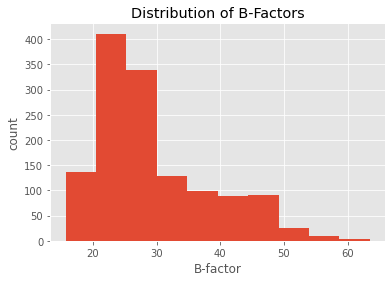

In [26]:
ppdb.df['ATOM']['b_factor'].plot(kind='hist')
plt.title('Distribution of B-Factors')
plt.xlabel('B-factor')
plt.ylabel('count')
plt.show()

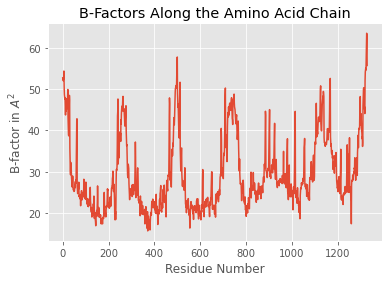

In [27]:
ppdb.df['ATOM']['b_factor'].plot(kind='line')
plt.title('B-Factors Along the Amino Acid Chain')
plt.xlabel('Residue Number')
plt.ylabel('B-factor in $A^2$')
plt.show()

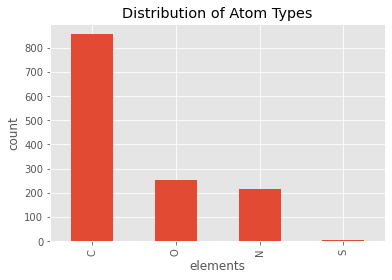

In [28]:
ppdb.df['ATOM']['element_symbol'].value_counts().plot(kind='bar')
plt.title('Distribution of Atom Types')
plt.xlabel('elements')
plt.ylabel('count')
plt.show()

## Computing the Root Mean Square Deviation

BioPandas also comes with certain convenience functions, for example, ...

The Root-mean-square deviation (RMSD) is simply a measure of the average distance between atoms of 2 protein or ligand structures. This calculation of the Cartesian error follows the equation:

$$RMSD(a, b) = \sqrt{\frac{1}{n} \sum^{n}_{i=1} \big((a_{ix})^2 + (a_{iy})^2 + (a_{iz})^2 \big)} \\
= \sqrt{\frac{1}{n} \sum^{n}_{i=1} || a_i + b_i||_2^2}$$

So, assuming that the we have the following 2 conformations of a ligand molecule

![](./img/ligand_rmsd.png)

we can compute the RMSD as follows:

In [29]:
from biopandas.pdb import PandasPdb

l_1 = PandasPdb().read_pdb('./data/lig_conf_1.pdb')
l_2 = PandasPdb().read_pdb('./data/lig_conf_2.pdb')
r = PandasPdb.rmsd(l_1.df['HETATM'], l_2.df['HETATM'],
                   s=None) # all atoms, including hydrogens
print('RMSD: %.4f Angstrom' % r)

RMSD: 2.6444 Angstrom


[File links: [lig_conf_1.pdb](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/lig_conf_1.pdb), [lig_conf_2.pdb](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/lig_conf_2.pdb)]

In [30]:
r = PandasPdb.rmsd(l_1.df['HETATM'], l_2.df['HETATM'], 
                   s='carbon') # carbon atoms only
print('RMSD: %.4f Angstrom' % r)

RMSD: 3.1405 Angstrom


In [31]:
r = PandasPdb.rmsd(l_1.df['HETATM'], l_2.df['HETATM'], 
                   s='heavy') # heavy atoms only
print('RMSD: %.4f Angstrom' % r)

RMSD: 1.9959 Angstrom


Similarly, we can compute the RMSD between 2 related protein structures:

![](./img/1t48_rmsd.png)

The hydrogen-free RMSD:

In [32]:
p_1 = PandasPdb().read_pdb('./data/1t48_995.pdb')
p_2 = PandasPdb().read_pdb('./data/1t49_995.pdb')
r = PandasPdb.rmsd(p_1.df['ATOM'], p_2.df['ATOM'], s='heavy')
print('RMSD: %.4f Angstrom' % r)

RMSD: 0.7377 Angstrom


Or the RMSD between the main chains only:

In [33]:
p_1 = PandasPdb().read_pdb('./data/1t48_995.pdb')
p_2 = PandasPdb().read_pdb('./data/1t49_995.pdb')
r = PandasPdb.rmsd(p_1.df['ATOM'], p_2.df['ATOM'], s='main chain')
print('RMSD: %.4f Angstrom' % r)

RMSD: 0.4781 Angstrom


<br>

## Filtering PDBs by Distance

We can use the `distance` method to compute the distance between each atom (or a subset of atoms) in our data frame and a three-dimensional reference point. For example:

In [34]:
p_1 = PandasPdb().read_pdb('./data/3eiy.pdb')

reference_point = (9.362, 41.410, 10.542)
distances = p_1.distance(xyz=reference_point, records=('ATOM',))

[File link: [3eiy.pdb](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/3eiy.pdb)]

The distance method returns a Pandas Series object:

In [35]:
distances.head()

0    19.267419
1    18.306060
2    16.976934
3    16.902897
4    18.124171
dtype: float64

And we can use this `Series` object, for instance, to select certain atoms in our DataFrame that fall within a desired distance threshold. For example, let's select all atoms that are within 7A of our reference point: 

In [36]:
all_within_7A = p_1.df['ATOM'][distances < 7.0]
all_within_7A.tail()

,record_name,atom_number,blank_1,atom_name,...,segment_id,element_symbol,charge,line_idx
786,ATOM,787,,CB,...,,C,NaN,1395
787,ATOM,788,,CG,...,,C,NaN,1396
788,ATOM,789,,CD1,...,,C,NaN,1397
789,ATOM,790,,CD2,...,,C,NaN,1398
790,ATOM,791,,N,...,,N,NaN,1399


Visualized in PyMOL, this subset (yellow surface) would look as follows:
    
![](./img/3eiy_7a.png)

## Converting Amino Acid codes from 3- to 1-letter codes

Residues in the `residue_name` field can be converted into 1-letter amino acid codes, which may be useful for further sequence analysis, for example, pair-wise or multiple sequence alignments:

In [37]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb().fetch_pdb('5mtn')
sequence = ppdb.amino3to1()
sequence.tail()

,chain_id,residue_name
1378,B,I
1386,B,N
1394,B,Y
1406,B,R
1417,B,T


As shown above, the `amino3to1` method returns a `DataFrame` containing the `chain_id` and `residue_name` of the translated 1-letter amino acids. If you like to work with the sequence as a Python list of string characters, you could do the following:

In [38]:
sequence_list = list(sequence.loc[sequence['chain_id'] == 'A', 'residue_name'])
sequence_list[-5:] # last 5 residues of chain A

['V', 'R', 'H', 'Y', 'T']

And if you prefer to work with the sequence as a string, you can use the `join` method: 

In [39]:
''.join(sequence.loc[sequence['chain_id'] == 'A', 'residue_name'])

'SLEPEPWFFKNLSRKDAERQLLAPGNTHGSFLIRESESTAGSFSLSVRDFDQGEVVKHYKIRNLDNGGFYISPRITFPGLHELVRHYT'

To iterate over the sequences of multi-chain proteins, you can use the `unique` method as shown below:

In [40]:
for chain_id in sequence['chain_id'].unique():
    print('\nChain ID: %s' % chain_id)
    print(''.join(sequence.loc[sequence['chain_id'] == chain_id, 'residue_name']))


Chain ID: A
SLEPEPWFFKNLSRKDAERQLLAPGNTHGSFLIRESESTAGSFSLSVRDFDQGEVVKHYKIRNLDNGGFYISPRITFPGLHELVRHYT

Chain ID: B
SVSSVPTKLEVVAATPTSLLISWDAPAVTVVYYLITYGETGSPWPGGQAFEVPGSKSTATISGLKPGVDYTITVYAHRSSYGYSENPISINYRT


## Wrapping it up - Saving PDB structures

Finally, let's talk about how to get the PDB structures out of the DataFrame format back into the beloved .pdb format.

Let's say we loaded a PDB structure, removed it from it's hydrogens:

In [41]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb().read_pdb('./data/3eiy.pdb.gz')
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']

[File link: [3eiy.pdb.gz](https://github.com/rasbt/biopandas/blob/master/docs/sources/tutorials/data/3eiy.pdb.gz?raw=true)]

We can save the file using the [`PandasPdb.to_pdb`](../api/biopandas.pdb#pandaspdbto_pdb) method:

In [42]:
ppdb.to_pdb(path='./data/3eiy_stripped.pdb', 
            records=None, 
            gz=False, 
            append_newline=True)

[File link: [3eiy_stripped.pdb](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/3eiy_stripped.pdb)]

By default, all records (that is, 'ATOM', 'HETATM', 'OTHERS', 'ANISOU') are written if we set `records=None`. Alternatively, let's say we want to get rid of the 'ANISOU' entries and produce a compressed gzip archive of our PDB structure:

In [43]:
ppdb.to_pdb(path='./data/3eiy_stripped.pdb.gz', 
            records=['ATOM', 'HETATM', 'OTHERS'], 
            gz=True, 
            append_newline=True)

[File link: [3eiy_stripped.pdb.gz](https://github.com/rasbt/biopandas/blob/master/docs/sources/tutorials/data/3eiy_stripped.pdb.gz?raw=true)]